In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import time
import math

# 1 数据读取
 - 每秒所有采集数据放置在一行，数据间用空格分隔，不同类型数据（例如空间变位的三个方向、风速和风向）之间用逗号分隔

#### 1.1 读入数据

In [2]:
path = r"..\数据\浦仪夹江大桥数据4.27\主跨跨中风速UA-G-02.csv"

df = pd.read_csv(path)
del df['纵桥向风速']

In [3]:
df.head()

,测点编号,采集时间,风攻角,风向,合成风速
0,UA-G-02,2021-04-27 19:00:00,-0.1122028149972544 -0.059836319323872164 -0.0...,237 238 237 235 239 245 245 247 243 253,2.14347848134755 2.1738905216224667 2.19184853...
1,UA-G-02,2021-04-27 19:00:01,-0.4860319293400963 -0.5425793241259905 -0.500...,258 259 261 266 276 266 259 261 249 253,1.7982491484774852 1.5880806024884253 1.561857...
2,UA-G-02,2021-04-27 19:00:02,-0.3099067765820303 -0.24233316665301483 -0.35...,254 260 265 271 272 281 279 276 274 268,1.8690371852908652 1.8335757415498275 1.920650...
3,UA-G-02,2021-04-27 19:00:03,0.06523394175231864 -0.15824032445087904 -0.25...,264 260 260 259 261 259 260 259 253 256,1.9942417105255823 1.903785702225962 1.9209372...
4,UA-G-02,2021-04-27 19:00:04,-0.12161902326134658 -0.12095364711952021 -0.1...,259 260 261 256 257 258 258 255 256 254,1.813394606807906 1.8233211456021674 1.7692088...


#### 1.2  数据校验

In [4]:
# 数据类型转换
def change_datatype(df):
    df["风攻角"] = df["风攻角"].apply(lambda x: np.array(x.split(" "), dtype = float))
    df["风向"] = df["风向"].apply(lambda x: np.array(x.split(" "), dtype = float))
    df["合成风速"] = df["合成风速"].apply(lambda x: np.array(x.split(" "), dtype = float))
    df["采集时间"] = df["采集时间"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    return df
df = change_datatype(df)
df.head()

,测点编号,采集时间,风攻角,风向,合成风速
0,UA-G-02,2021-04-27 19:00:00,"[-0.1122028149972544, -0.059836319323872164, -...","[237.0, 238.0, 237.0, 235.0, 239.0, 245.0, 245...","[2.14347848134755, 2.1738905216224667, 2.19184..."
1,UA-G-02,2021-04-27 19:00:01,"[-0.4860319293400963, -0.5425793241259905, -0....","[258.0, 259.0, 261.0, 266.0, 276.0, 266.0, 259...","[1.7982491484774852, 1.5880806024884253, 1.561..."
2,UA-G-02,2021-04-27 19:00:02,"[-0.3099067765820303, -0.24233316665301483, -0...","[254.0, 260.0, 265.0, 271.0, 272.0, 281.0, 279...","[1.8690371852908652, 1.8335757415498275, 1.920..."
3,UA-G-02,2021-04-27 19:00:03,"[0.06523394175231864, -0.15824032445087904, -0...","[264.0, 260.0, 260.0, 259.0, 261.0, 259.0, 260...","[1.9942417105255823, 1.903785702225962, 1.9209..."
4,UA-G-02,2021-04-27 19:00:04,"[-0.12161902326134658, -0.12095364711952021, -...","[259.0, 260.0, 261.0, 256.0, 257.0, 258.0, 258...","[1.813394606807906, 1.8233211456021674, 1.7692..."


In [5]:
# 查看每秒内的 风攻角 风向 合成风速 的采集次数是不是都一样多
df['check'] = len(df['风攻角']) * len(df['合成风速']) / len(df['风向']) /  len(df['风向'])
print(df[df['check']!=1])
del df['check']

Empty DataFrame
Columns: [测点编号, 采集时间, 风攻角, 风向, 合成风速, check]
Index: []


 - 还好一样多，不然clean很麻烦

In [6]:
def data_verification(df):
    #统计每秒钟内的采样频率
    df["每秒采样频率"] = df["合成风速"].apply(lambda x: len(x))
    print(df["每秒采样频率"].describe() ,"\n")
    
    # 校验每小时漏采或多采的情况
    tmp_Series = df["采集时间"].apply(lambda x: x.strftime("%Y-%m-%d %H时")).value_counts()
    tmp_Series.index = [datetime.datetime.strptime(x[:-1],'%Y-%m-%d %H') for x in tmp_Series.index]
    tmp_Series = tmp_Series - 60*60  #（正常情况下有3600条数据）
    print(tmp_Series)
    tmp_Series = tmp_Series.sort_index()

    plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
    plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
    plt.figure (figsize= (15,4))
    plt.bar(x = tmp_Series.index[:-2], height = tmp_Series.values[:-2], width = 0.041)
    plt.xlabel("Time",fontsize='10')
    plt.ylabel("Bias",fontsize='10')
    plt.title("每小时漏采或多采的情况",fontsize='20')
    plt.plot()

count    172578.000000
mean         10.018050
std           0.594845
min           1.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          45.000000
Name: 每秒采样频率, dtype: float64 

2021-04-28 18:00:00     0
2021-04-29 17:00:00     0
2021-04-27 20:00:00     0
2021-04-28 02:00:00     0
2021-04-29 12:00:00     0
2021-04-29 09:00:00    -1
2021-04-29 08:00:00    -1
2021-04-29 06:00:00    -1
2021-04-28 15:00:00    -2
2021-04-29 13:00:00    -2
2021-04-29 14:00:00    -2
2021-04-29 01:00:00    -2
2021-04-28 05:00:00    -2
2021-04-28 01:00:00    -2
2021-04-27 21:00:00    -2
2021-04-28 16:00:00    -2
2021-04-29 05:00:00    -3
2021-04-28 22:00:00    -3
2021-04-28 21:00:00    -3
2021-04-29 07:00:00    -3
2021-04-29 11:00:00    -3
2021-04-28 13:00:00    -3
2021-04-28 00:00:00    -3
2021-04-28 10:00:00    -3
2021-04-28 04:00:00    -3
2021-04-29 15:00:00    -3
2021-04-28 14:00:00    -4
2021-04-28 08:00:00    -4
2021-04-29 10:00:00    -4
2021-04-28 17:00:00    -4
2021-

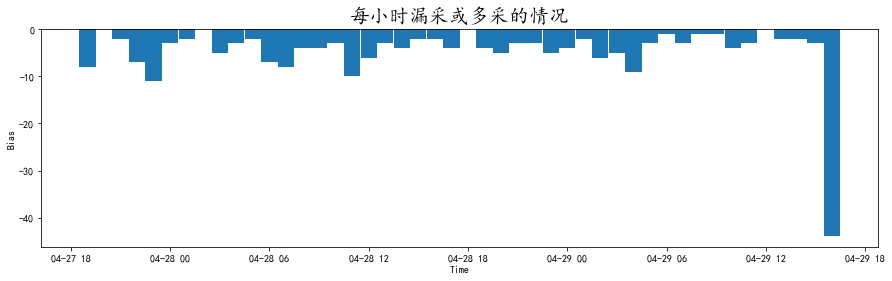

In [7]:
data_verification(df)

 - 采样频率为10hZ,但个别秒存在多采或少采的情况
 - 采样时间以一秒为单位增加，每小时应该存在3600条数据，但实际上存在偏差，特别是2021-04-29 16时的数据

# 2 数据预处理
 - 针对数据校验的结果，对数据进行进一步处理

#### 2.1 数据展开

In [8]:
df.sort_values(by="采集时间",axis=0,ascending=True,inplace=True)
df.drop_duplicates(subset=['采集时间'], keep='first', inplace=True)
df.reset_index(inplace=True)
del df['index']

In [9]:
df.head()

,测点编号,采集时间,风攻角,风向,合成风速,每秒采样频率
0,UA-G-02,2021-04-27 19:00:00,"[-0.1122028149972544, -0.059836319323872164, -...","[237.0, 238.0, 237.0, 235.0, 239.0, 245.0, 245...","[2.14347848134755, 2.1738905216224667, 2.19184...",10
1,UA-G-02,2021-04-27 19:00:01,"[-0.4860319293400963, -0.5425793241259905, -0....","[258.0, 259.0, 261.0, 266.0, 276.0, 266.0, 259...","[1.7982491484774852, 1.5880806024884253, 1.561...",10
2,UA-G-02,2021-04-27 19:00:02,"[-0.3099067765820303, -0.24233316665301483, -0...","[254.0, 260.0, 265.0, 271.0, 272.0, 281.0, 279...","[1.8690371852908652, 1.8335757415498275, 1.920...",10
3,UA-G-02,2021-04-27 19:00:03,"[0.06523394175231864, -0.15824032445087904, -0...","[264.0, 260.0, 260.0, 259.0, 261.0, 259.0, 260...","[1.9942417105255823, 1.903785702225962, 1.9209...",10
4,UA-G-02,2021-04-27 19:00:04,"[-0.12161902326134658, -0.12095364711952021, -...","[259.0, 260.0, 261.0, 256.0, 257.0, 258.0, 258...","[1.813394606807906, 1.8233211456021674, 1.7692...",10


In [11]:
##############################################################
# @desc: 对数据的每一行进行处理，返回dataframe
##############################################################
def produce_unit(x):
    # 生成时间序列
    time_list = pd.date_range(start=x["采集时间"], periods=10, freq='100ms')
    # 风速
    z_angel = x["风攻角"]
    xy_angel = x["风向"]
    v = x["合成风速"]
    if len(v) < 10:
        nan_list = np.full(10-len(v), np.nan)
        v = np.append(v,nan_list)
        xy_angel = np.append(xy_angel,nan_list)
        z_angel = np.append(z_angel,nan_list)
    elif len(v) > 10:
        z_angel = z_angel[:10]
        xy_angel = xy_angel[:10]
        v = v[:10]
    return pd.DataFrame({'采集时间':time_list,'风功角':z_angel, '风向':xy_angel, '合成风速':v })
    
##############################################################
# @desc: 对数据的每一行进行处理，返回dataframe
# @dependencies: produce_unit
##############################################################
def preprocessing(df):
    intermediary = df.apply(lambda x: produce_unit(x), axis = 1, result_type = 'reduce')  # intermediary是一个Seriess，但每个数据是一个dataFrame
    result = intermediary[0]   # 初始化
    for i in range(1, len(intermediary)):
        # 判断是否不连续
        intervel = (intermediary[i]["采集时间"][0] - intermediary[i-1]["采集时间"][0]).seconds
        if (intervel > 1):
            adding = pd.DataFrame(
                {'采集时间':pd.date_range(start=intermediary[i-1]["采集时间"][0] + datetime.timedelta(minutes=1), periods=int(intervel -1)*10, freq='100ms'),
                 '风功角':np.full(int(intervel-1)*10, np.nan),
                 '风向':np.full(int(intervel-1)*10, np.nan),
                 '合成风速':np.full(int(intervel-1)*10, np.nan)
                }
            ) 
            result = pd.concat([result,adding,intermediary[i]])
        else:
            result = pd.concat([result,intermediary[i]])
    result.reset_index(inplace = True)
    del result['index']
    return result

In [12]:
disposed_df = df.copy()
disposed_df = preprocessing(disposed_df)

KeyboardInterrupt: 

In [19]:
disposed_df.to_csv('..\数据\浦仪夹江大桥数据4.27\disposed\跨中风速.csv')

#### 2.2 归一化

In [3]:
disposed_df = pd.read_csv('..\数据\浦仪夹江大桥数据5.4\disposed\跨中风速.csv',index_col=False)
del disposed_df['Unnamed: 0']

# def normalization(df,columns=[]):
#     for col in columns:
#         df[columns] = df[columns] / (df[columns].max() - df[columns].min()) 
#     return df

# cols = ['合成风速']
# disposed_df = normalization(disposed_df,cols)

In [7]:
disposed_df

,采集时间,风功角,风向,合成风速
0,2021-05-04 00:00:00.000,-0.070155,294.0,1.854562
1,2021-05-04 00:00:00.100,-0.099150,296.0,1.919427
2,2021-05-04 00:00:00.200,-0.137848,296.0,1.746568
3,2021-05-04 00:00:00.300,-0.126489,296.0,1.743932
4,2021-05-04 00:00:00.400,-0.056757,300.0,1.762839
...,...,...,...,...
1727925,2021-05-05 23:59:52.500,0.099669,5.0,1.105486
1727926,2021-05-05 23:59:52.600,0.128911,6.0,1.089036
1727927,2021-05-05 23:59:52.700,0.151375,8.0,1.193650
1727928,2021-05-05 23:59:52.800,0.076772,8.0,1.173456


#### 2.3 原始数据可视化

In [16]:
# 
d = disposed_df.copy()
bridge_angel = 250

d['竖向风速'] = d['合成风速'] * np.sin(d['风功角']* np.pi / 180)
d['横桥向风速'] = d['合成风速'] * np.cos(d['风功角']* np.pi / 180) * np.sin((d['风向'] - bridge_angel)* np.pi / 180)
d['纵桥向风速'] = d['合成风速'] * np.cos(d['风功角']* np.pi / 180) * np.cos((d['风向'] - bridge_angel)* np.pi / 180)


In [17]:
d['采集时间'] = d["采集时间"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f')) 
d.index = d['采集时间']
del d['采集时间']

Text(0.5, 1.0, '竖向风速')

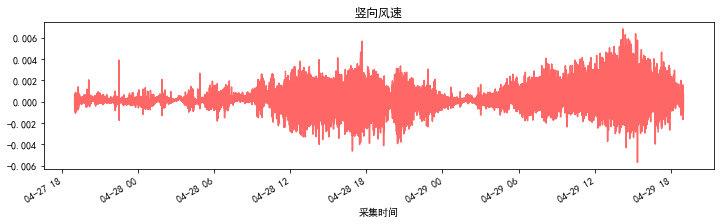

In [18]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
d['竖向风速'].plot(figsize=(12,3),color='red',alpha=0.6)
plt.title('竖向风速')

Text(0.5, 1.0, '横桥向风速')

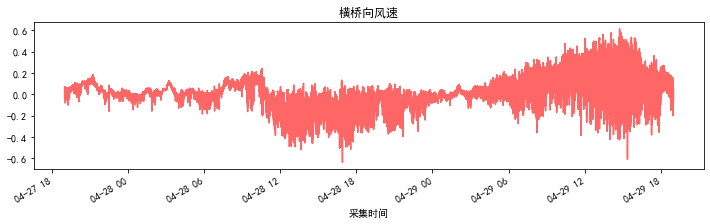

In [19]:
d['横桥向风速'].plot(figsize=(12,3),color='red',alpha=0.6)
plt.title('横桥向风速')

Text(0.5, 1.0, '纵桥向风速')

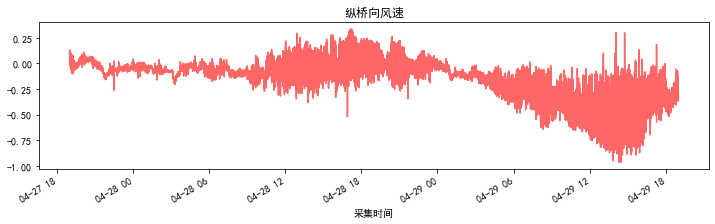

In [20]:
d['纵桥向风速'].plot(figsize=(12,3),color='red',alpha=0.6)
plt.title('纵桥向风速')

# 3 数据分析

#### 3.1 以十分钟为单位划分数据集
 - 计算窗体时间内的平均Vx、Vy、Vz和平均风速的风向
 - 计算紊流度：
     - Iu = sigma_vx/sqrt(vx^2+vy^2)
     - Iv = sigma_vy/sqrt(vx^2+vy^2)
     - Iw = sigma_vz/sqrt(vx^2+vy^2)

In [8]:
def func(x,bridge_angel):
    d = {}
    d['采集时段'] = x['采集时间'].min()
    d['Vx'] = (x['合成风速'] * np.cos(x['风功角']* np.pi / 180) * np.cos(x['风向']* np.pi / 180)).mean()
    d['Vy'] = (x['合成风速'] * np.cos(x['风功角']* np.pi / 180) * np.sin(x['风向']* np.pi / 180)).mean()
    d['平均风向'] = round(x['风向'].mean(),3)
    d['平均风功角'] = round(x['风功角'].mean(),3)
    # 计算紊流度
    sigma_vx = (x['合成风速'] * np.cos(x['风功角']* np.pi / 180) * np.cos(x['风向']* np.pi / 180)).std() 
    sigma_vy = (x['合成风速'] * np.cos(x['风功角']* np.pi / 180) * np.sin(x['风向']* np.pi / 180)).std()
    sigma_vz = (x['合成风速'] * np.sin(x['风功角']* np.pi / 180)).std()
    d['Ix'] = sigma_vx / np.sqrt(d['Vx']**2+d['Vy']**2)
    d['Iy'] = sigma_vy / np.sqrt(d['Vx']**2+d['Vy']**2)
    d['Iz'] = sigma_vz / np.sqrt(d['Vx']**2+d['Vy']**2)
    
    d['竖向风速'] = (x['合成风速'] * np.sin(x['风功角']* np.pi / 180)).mean()
    d['横桥向风速'] = (x['合成风速'] * np.cos(x['风功角']* np.pi / 180) * np.sin((x['风向'] - bridge_angel)* np.pi / 180)).mean()
    d['纵桥向风速'] = (x['合成风速'] * np.cos(x['风功角']* np.pi / 180) * np.cos((x['风向'] - bridge_angel)* np.pi / 180)).mean()
    d['总风速'] = x['合成风速'].mean()
    return pd.Series(d, index=['采集时段','总风速','纵桥向风速','横桥向风速','竖向风速','平均风向','平均风功角','Ix','Iy','Iz'])

############################################################
# @desc：获取窗体时间内的统计值
# @param：
#     df：数据集
#     bridge_angel: 桥身走向（方向：北偏东、顺时针）
#     interval：窗体事件(/s)
############################################################
def get_stats(df, bridge_angel = 0,interval = 60*10, freq = 10):
    df["class"] = np.array(df.index.values / (freq*interval), dtype=int)
    # 分组计算各项统计值
    result = df.groupby('class').apply(func, bridge_angel)
    
    
    # 下面是平均风速的另外一种算法
    # 计算平均风速、横桥向风速、纵桥向风速
#     result['平均风速'] = np.sqrt(result['Vx']**2+result['Vy']**2+result['Vz']**2)
#     result['纵桥向风速'] = result['平均风速'] * np.cos((result['平均风向'] - bridge_angel)* np.pi / 180)
#     result['横桥向风速'] = result['平均风速'] * np.sin((result['平均风向'] - bridge_angel)* np.pi / 180)
    return result

In [9]:
stats = get_stats(disposed_df, bridge_angel = 250, interval = 60*10, freq = 10)

In [10]:
stats

,采集时段,总风速,纵桥向风速,横桥向风速,竖向风速,平均风向,平均风功角,Ix,Iy,Iz
class,,,,,,,,,,
0,2021-05-04 00:00:00.000,3.417032,1.187256,3.167863,0.002319,319.683,0.040,0.118981,0.156224,0.000839
1,2021-05-04 00:10:00.000,3.756233,0.954048,3.607304,0.002987,325.204,0.048,0.114395,0.115133,0.000827
2,2021-05-04 00:20:00.000,3.256599,1.091168,3.042355,0.002002,320.049,0.036,0.140253,0.106636,0.000949
3,2021-05-04 00:30:00.000,2.811122,1.010055,2.571265,0.001292,318.345,0.028,0.179952,0.164529,0.001335
4,2021-05-04 00:40:00.000,3.387792,1.788316,2.850825,0.001144,307.873,0.022,0.122794,0.127564,0.000999
...,...,...,...,...,...,...,...,...,...,...
283,2021-05-05 23:10:00.000,2.921299,0.063002,2.883484,0.005557,334.795,0.113,0.233184,0.151101,0.001450
284,2021-05-05 23:20:00.000,3.339270,-0.145917,3.318623,0.006663,341.699,0.116,0.141730,0.098999,0.000952
285,2021-05-05 23:30:00.000,3.351036,0.074186,3.331053,0.005735,338.502,0.099,0.115941,0.101257,0.001030


In [11]:
stats.to_csv('..\数据\浦仪夹江大桥数据5.4\processed_data\跨中风速统计值.csv')

# 附 风速探究

In [19]:
disposed_df = pd.read_csv('..\数据\浦仪夹江大桥数据4.27\processed_data\跨中风速统计值.csv',index_col=False)
disposed_df.head()

,class,采集时段,总风速,纵桥向风速,横桥向风速,竖向风速,平均风向,平均风功角,Ix,Iy,Iz
0,0,2021-04-27 19:00:00.000,0.918964,0.555902,0.213161,0.000929,204.412,0.116,0.682133,1.324335,0.008024
1,1,2021-04-27 19:10:00.000,1.063643,-0.860948,0.493522,0.001446,46.659,0.087,0.344621,0.411306,0.002992
2,2,2021-04-27 19:20:00.000,1.000701,-0.626420,0.757921,0.001686,32.728,0.095,0.169041,0.194447,0.001526
3,3,2021-04-27 19:30:00.000,1.256473,-0.424954,1.164158,0.002211,171.123,0.101,0.157634,0.162610,0.001186
4,4,2021-04-27 19:40:00.000,1.366426,0.212116,1.311205,0.003367,330.609,0.147,0.179761,0.261767,0.001205


In [20]:
disposed_df['']

,采集时间,风功角,风向,合成风速
0,2021-04-27 19:00:00.000,-0.112203,237.0,2.143478
1,2021-04-27 19:00:00.100,-0.059836,238.0,2.173891
2,2021-04-27 19:00:00.200,-0.041073,237.0,2.191849
3,2021-04-27 19:00:00.300,-0.097039,235.0,2.270683
4,2021-04-27 19:00:00.400,-0.124888,239.0,2.328132
...,...,...,...,...
1727905,2021-04-29 18:59:50.500,-0.048296,65.0,6.007004
1727906,2021-04-29 18:59:50.600,-0.031343,67.0,6.062978
1727907,2021-04-29 18:59:50.700,-0.030294,64.0,5.942727
1727908,2021-04-29 18:59:50.800,-0.011804,64.0,5.930413


#### 气象局记录